# Rock and States

A tutorial on Rock and States components and its transformations.

### Content
* [Basic properties](#Basic-properties)
* [Visualization](#Visualization)
* [Transformations](#Transformations)
    * [Generic methods](#Generic-methods)
    * [Upscaling](#Upscaling)

## Basic properties

In essence, `Rock` and `States` components are very similar, the only difference is that 
`Rock` component contains time-independent model properties in 3D arrays, e.g.
* PORO - porosity
* PERMX - x-permeability
* PERMZ - y-permeability
* PERMY - z-permeability

while `States` component contains time-dependent model properties, in 4D arrays (i.e. three spatial and a single time axis), e.g.
* PRESSURE - pore volume pressure
* SOIL - oil saturation
* SWAT - water saturation
* SGAS - gas saturation
* RS - dissolved gas content

In this notebook we will mostly consider `Rock` component.

Required imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield import Field

Load a model (this is the HDF5 model created in the first [tutorial](./01.Basics.ipynb)):

In [2]:
model = Field(path='./norne_simplified.hdf5').load()

INFO:Field:===== Field summary =====
INFO:Field:AQUIFERS attributes: 
INFO:Field:GRID attributes: MAPAXES, ACTNUM, COORD, DIMENS, ZCORN
INFO:Field:ROCK attributes: PERMX, PERMY, PERMZ, PORO
INFO:Field:STATES attributes: PRESSURE, RS, SGAS, SOIL, SWAT
INFO:Field:TABLES attributes: DENSITY, PVDG, PVTO, PVTW, ROCK, SGOF, SWOF
INFO:Field:WELLS attributes: WELSPECS, WCONINJE, WCONPROD, RESULTS, WFRAC, COMPDAT, WELLTRACK
INFO:Field:=========================


List of rock attributes:

In [3]:
model.rock.attributes

('PERMX', 'PERMY', 'PERMZ', 'PORO')

Attributes are case-insensitive:

In [4]:
(model.rock.poro == model.rock.PORO).all()

True

Attrubutes are in a spatial shape by default (e.g. 3D or 4D):

In [5]:
model.rock.permx.shape

(46, 112, 22)

## Visualization

Array attributes can be visualized in 3D using a separate interactive window:
```python
model.show(attr='PORO')
```
or, alternalively, one can use a simplified inline 2D visualization

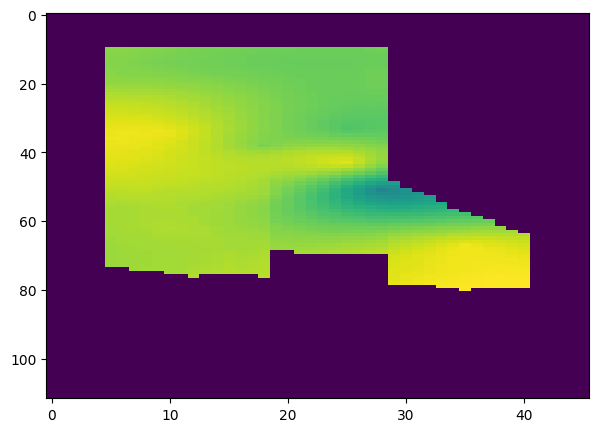

In [6]:
model.rock.show_cube(attr='poro', z=8, actnum=model.grid.actnum, figsize=(7, 5))

If slice is not specified, an interactive 2D mode with slice widgets will be activated:

In [7]:
model.rock.show_cube(attr='poro', actnum=model.grid.actnum, figsize=(12, 5))

interactive(children=(IntSlider(value=23, description='x', max=45), IntSlider(value=56, description='y', max=1…

Also for quick estimation of properties one can plot a histogram:

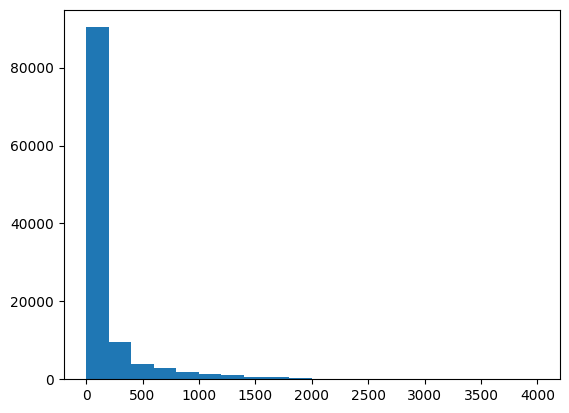

In [8]:
model.rock.show_histogram('permx', actnum=model.grid.actnum, bins=20)

## Transformations

Components contain many build-in methods. In general, these methods have similar signature: one needs to specify an attribute or a list of attributes, decide whether to save the result inplace or output them and provide additional keywords for particular method.

### Generic methods

Rock contain a number of generic methods inherited from `skimage` for ndarrays transformation. 
For example, arrays can be 
* resized

In [9]:
poro = model.rock.resize(attr='poro', output_shape=(10, 12, 14), inplace=False)
poro.shape

(10, 12, 14)

* flipped

In [10]:
poro = model.rock.flip(attr='poro', axis=0, inplace=False)

* rotated

In [11]:
poro = model.rock.rot90(attr='poro', k=1, inplace=False)
print('Original shape:', model.rock.poro.shape)
print('Rotated shape:', poro.shape)

Original shape: (46, 112, 22)
Rotated shape: (112, 46, 22)


* randomized with some noise:

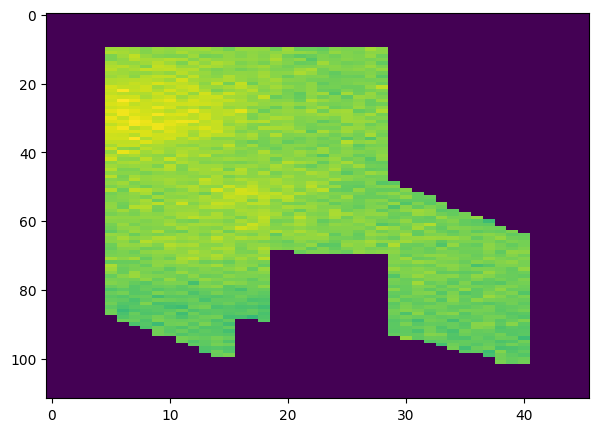

In [12]:
model.rock.random_noise(attr='poro', var=0.0001, inplace=True)
model.rock.show_cube(attr='poro', z=12, actnum=model.grid.actnum, figsize=(7, 5))

Also many methods from [`scipy.ndarray`](https://docs.scipy.org/doc/scipy/reference/ndimage.html#) module are included. E.g. we can apply median filter:

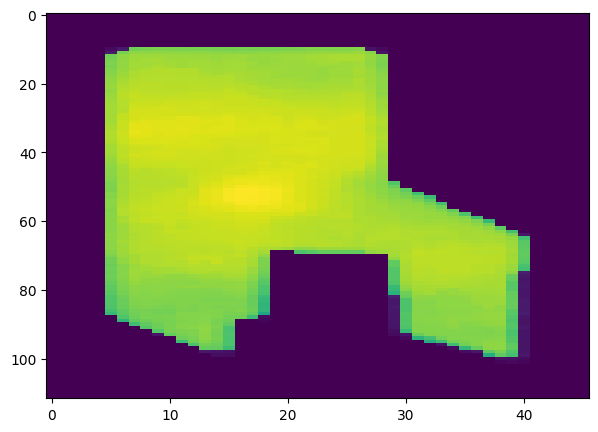

In [13]:
model.rock.median_filter(attr='poro', size=5, inplace=True)
model.rock.show_cube(attr='poro', z=12, actnum=model.grid.actnum, figsize=(7, 5))

Custom functions that accept data as its first argument can also be applied:

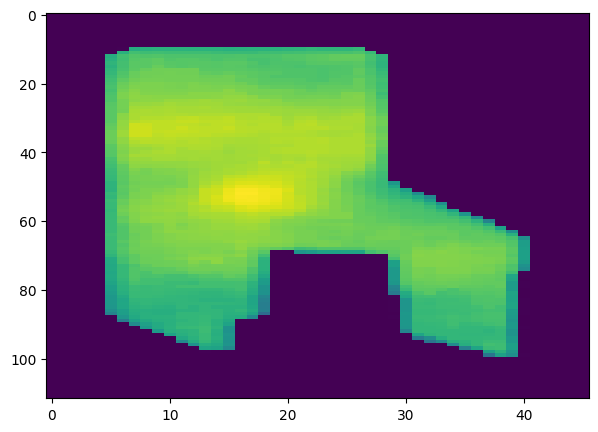

In [14]:
model.rock.apply(lambda x: x**2, attr='poro', inplace=True)
model.rock.show_cube(attr='poro', z=12, actnum=model.grid.actnum, figsize=(7, 5))

### Upscaling

Unscaling of rock properties is a bit tricker than a generic arrays rescaling. For porosity upscaling a volume averaging a required: 

In [15]:
up_poro = model.rock.upscale(attr='poro', factors=2, volumes=model.grid.cell_volumes)

For permeability upscaling porosity is a reasonable weighting factor:

In [16]:
up_permx = model.rock.upscale(attr='permx', factors=2, volumes=model.grid.cell_volumes,
                              weights=model.rock.poro)

So far we are done with spatial components and move to more soecific components in the next notebooks.